In [1]:
!pip install tensorflow-gpu==2.0.0
!pip install tensorflow_hub

     |████████████████████████████████| 380.8 MB 36 kB/s 
     |████████████████████████████████| 50 kB 5.6 MB/s 
     |████████████████████████████████| 3.8 MB 40.7 MB/s 
     |████████████████████████████████| 449 kB 54.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=6ee14e346af174f992449f487f2d7178b2881789c003690e76aa14c02cf73405
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

In [2]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [3]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.8.0
Hub version:  0.12.0
Eager mode:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [4]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228827136/228813984 [==============================] - 2s 0us/step


In [5]:
# Create data generator for training and validation

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


In [6]:
# Learn more about data batches

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [7]:
# Learn about dataset labels

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Daisy' 'Dandelion' 'Roses' 'Sunflowers' 'Tulips']


In [8]:
from time import time
#performing same process on the dataset
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [10]:
# Run model training
from time import time
#performing same process on the dataset
start_opt = time()
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=10,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history
finish_opt = time()
f"Execution time with TensorFlow to train: {(finish_opt - start_opt):.2f} s"

Epoch 1/10
92/92 [==============================] - 32s 189ms/step - loss: 0.9182 - acc: 0.6584 - val_loss: 0.4594 - val_acc: 0.8468
Epoch 2/10
92/92 [==============================] - 23s 246ms/step - loss: 0.4713 - acc: 0.8295 - val_loss: 0.4009 - val_acc: 0.8577
Epoch 3/10
92/92 [==============================] - 17s 182ms/step - loss: 0.3845 - acc: 0.8605 - val_loss: 0.3776 - val_acc: 0.8714
Epoch 4/10
92/92 [==============================] - 17s 181ms/step - loss: 0.3325 - acc: 0.8833 - val_loss: 0.3710 - val_acc: 0.8687
Epoch 5/10
92/92 [==============================] - 22s 236ms/step - loss: 0.3107 - acc: 0.8938 - val_loss: 0.3339 - val_acc: 0.8810
Epoch 6/10
92/92 [==============================] - 16s 175ms/step - loss: 0.2674 - acc: 0.9064 - val_loss: 0.3451 - val_acc: 0.8769
Epoch 7/10
92/92 [==============================] - 16s 175ms/step - loss: 0.2607 - acc: 0.9136 - val_loss: 0.3332 - val_acc: 0.8810
Epoch 8/10
92/92 [==============================] - 17s 181ms/step - 

'Execution time with TensorFlow to train: 196.10 s'

In [11]:

final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)

23/23 [==============================] - 5s 194ms/step - loss: 0.3436 - acc: 0.8810


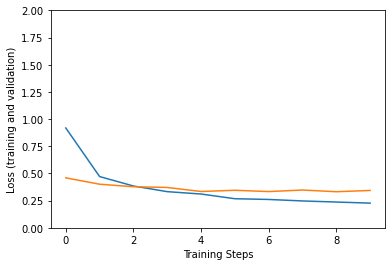

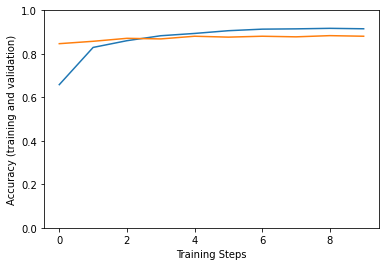

In [12]:
# Visualize training process

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

We are happy with our model’s performance, Now. export our model to  directory. This will export your model as a TFLite model. After that we'll do inference on reloaded model, so if you come with a model already trained, it'll be easier to inspect it.


In [13]:
FLOWERS_SAVED_MODEL = "saved_models/FlowerModel2"
tf.saved_model.save(model, FLOWERS_SAVED_MODEL)

INFO:tensorflow:Assets written to: saved_models/FlowerModel2/assets


INFO:tensorflow:Assets written to: saved_models/FlowerModel2/assets


In [14]:
flowers_model = hub.load(FLOWERS_SAVED_MODEL)
print(flowers_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7fc2d24ba150>


In [17]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
tf_model_predictions = flowers_model(val_image_batch)

In [18]:
tf_pred_dataframe = pd.DataFrame(tf_model_predictions.numpy())
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Daisy,Dandelion,Roses,Sunflowers,Tulips
0,0.99752218,0.00004156,0.00006599,0.00115470,0.00121561
1,0.00825227,0.98992121,0.00007559,0.00160001,0.00015094
2,0.01971897,0.00270733,0.12511809,0.00022930,0.85222626
3,0.03196456,0.04250766,0.00133980,0.92191684,0.00227113
4,0.00509159,0.00616450,0.00432075,0.96292931,0.02149384


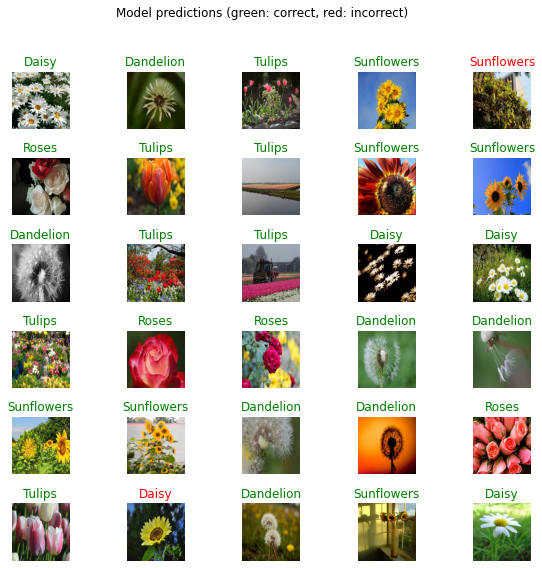

In [22]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
# Print images batch and labels predictions

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

 ### TensorFlow Lite inference typically follows the following steps
 1. Now with our model
 2. Load you model and allocate the tensors.
 3. Get the input and output tensors
 4. Read in a sample image you want the model to predict  and decode to a tensor
 5. Set the tensor to point to the input data to be inferred, then run the inference (from 3)
 6. Make the prediction



In [19]:
!mkdir "tflite_models"

In [20]:
TFLITE_MODEL = "tflite_models/flowers.tflite"
TFLITE_QUANT_MODEL = "tflite_models/flowers_quant.tflite"

In [27]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: save/fine_tuning/assets


INFO:tensorflow:Assets written to: save/fine_tuning/assets


In [37]:
from time import time
# Load TFLite model and allocate tensors.

start_unopt = time()
# Load TFLite model and see some details about input/output

tflite_interpreter = tf.lite.Interpreter(model_path='/content/model.tflite')

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_keras_layer_input:0
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 5]
type: <class 'numpy.float32'>


In [38]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_keras_layer_input:0
shape: [ 32 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [32  5]
type: <class 'numpy.float32'>


In [39]:
tflite_interpreter.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter.invoke()

tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)

Prediction results shape: (32, 5)


In [40]:
# Load quantized TFLite model
tflite_interpreter_quant = tf.lite.Interpreter(model_path= '/content/model.tflite')

# Learn about its input and output details
input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

# Resize input and output tensors to handle batch of 32 images
tflite_interpreter_quant.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter_quant.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter_quant.allocate_tensors()

input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

# Run inference
tflite_interpreter_quant.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter_quant.invoke()

tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
print("\nPrediction results shape:", tflite_q_model_predictions.shape)
finish_unopt = time()

f"Execution time for  TensorFlowlite Inference: {(finish_unopt - start_unopt):.2f} s"


== Input details ==
name: serving_default_keras_layer_input:0
shape: [ 32 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [32  5]
type: <class 'numpy.float32'>

Prediction results shape: (32, 5)


'Execution time for  TensorFlowlite Inference: 6.21 s'

In [41]:
# Convert prediction results to Pandas dataframe, for better visualization

tflite_q_pred_dataframe = pd.DataFrame(tflite_q_model_predictions)
tflite_q_pred_dataframe.columns = dataset_labels

print("TFLite Inference prediction results for the first elements")
tflite_q_pred_dataframe.head()

TFLite Inference prediction results for the first elements


,Daisy,Dandelion,Roses,Sunflowers,Tulips
0,0.99752206,0.00004156,0.00006599,0.00115471,0.00121561
1,0.00825217,0.98992133,0.00007559,0.00160001,0.00015094
2,0.01971904,0.00270735,0.12511951,0.00022930,0.85222489
3,0.03196476,0.04250785,0.00133982,0.92191643,0.00227115
4,0.00509158,0.00616453,0.00432076,0.96292925,0.02149383


In [42]:
# Concatenate results from all models

all_models_dataframe = pd.concat([tf_pred_dataframe, 
                                   
                                  tflite_q_pred_dataframe], 
                                 keys=['TF Model', 'TFLite'],
                                 axis='columns')
all_models_dataframe.head()

TF Model                                                      TFLite  \
        Daisy   Dandelion       Roses  Sunflowers      Tulips       Daisy   
0  0.99752218  0.00004156  0.00006599  0.00115470  0.00121561  0.99752206   
1  0.00825227  0.98992121  0.00007559  0.00160001  0.00015094  0.00825217   
2  0.01971897  0.00270733  0.12511809  0.00022930  0.85222626  0.01971904   
3  0.03196456  0.04250766  0.00133980  0.92191684  0.00227113  0.03196476   
4  0.00509159  0.00616450  0.00432075  0.96292931  0.02149384  0.00509158   

                                                   
    Dandelion       Roses  Sunflowers      Tulips  
0  0.00004156  0.00006599  0.00115471  0.00121561  
1  0.98992133  0.00007559  0.00160001  0.00015094  
2  0.00270735  0.12511951  0.00022930  0.85222489  
3  0.04250785  0.00133982  0.92191643  0.00227115  
4  0.00616453  0.00432076  0.96292925  0.02149383

In [44]:
# Swappin columns to have side by side comparison

all_models_dataframe = all_models_dataframe.swaplevel(axis='columns')[tflite_q_pred_dataframe.columns]
all_models_dataframe.head()

Daisy               Dandelion                   Roses              \
     TF Model      TFLite    TF Model      TFLite    TF Model      TFLite   
0  0.99752218  0.99752206  0.00004156  0.00004156  0.00006599  0.00006599   
1  0.00825227  0.00825217  0.98992121  0.98992133  0.00007559  0.00007559   
2  0.01971897  0.01971904  0.00270733  0.00270735  0.12511809  0.12511951   
3  0.03196456  0.03196476  0.04250766  0.04250785  0.00133980  0.00133982   
4  0.00509159  0.00509158  0.00616450  0.00616453  0.00432075  0.00432076   

   Sunflowers                  Tulips              
     TF Model      TFLite    TF Model      TFLite  
0  0.00115470  0.00115471  0.00121561  0.00121561  
1  0.00160001  0.00160001  0.00015094  0.00015094  
2  0.00022930  0.00022930  0.85222626  0.85222489  
3  0.92191684  0.92191643  0.00227113  0.00227115  
4  0.96292931  0.96292925  0.02149384  0.02149383

We are highlighting the differneces between the predictions

In [45]:

def highlight_diff(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    other = data.xs('TF Model', axis='columns', level=-1)
    return pd.DataFrame(np.where(data.ne(other, level=0), attr, ''),
                        index=data.index, columns=data.columns)

all_models_dataframe.style.apply(highlight_diff, axis=None)

As we can see, in most cases predictions are different between all models, usually by small factors. High-confidence predictions between TensorFlow and TensorFlow Lite models are very close to each other (in some cases there are even similar).

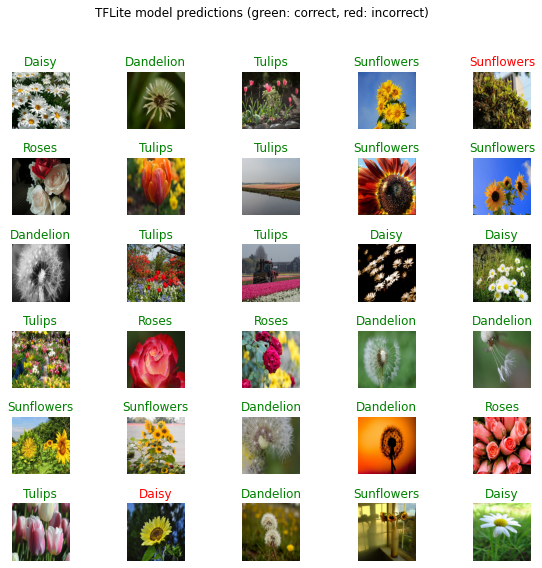

In [48]:
#Print images batch and labels predictions for TFLite Model

tflite_predicted_ids = np.argmax(tflite_model_predictions, axis=-1)
tflite_predicted_labels = dataset_labels[tflite_predicted_ids]
tflite_label_id = np.argmax(val_label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if tflite_predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(tflite_predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("TFLite model predictions (green: correct, red: incorrect)")

We can see the amount of speed with which we can predict using Tensorflowlite inferences. Its a good way to create deep networks and utilize the same repeatedly.